## 1. Bibliotecas

In [431]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from matplotlib_venn import venn2
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import Holt
import warnings
from scipy.signal import periodogram
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 2. Apresentar o dataset e análise exploratória:

### a) Estatísticas descritivas (describe, médias móveis etc.)

In [432]:
url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.21086/dados?formato=json"

response = requests.get(url)

data = response.json()
df = pd.DataFrame(data)
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
df['valor'] = df['valor'].str.replace(',', '.').astype(float)
df.set_index('data', inplace=True)
display(df.head())
df.describe()

,valor
data,
2011-03-01,3.18
2011-04-01,3.33
2011-05-01,3.49
2011-06-01,3.42
2011-07-01,3.57


,valor
count,175.000000
mean,3.284514
std,1.086064
min,1.450000
25%,2.600000
50%,3.320000
75%,3.745000
max,5.940000


In [433]:
df.describe()

,valor
count,175.000000
mean,3.284514
std,1.086064
min,1.450000
25%,2.600000
50%,3.320000
75%,3.745000
max,5.940000


### b) Visualização (plotar a série)

<Figure size 1200x1000 with 0 Axes>

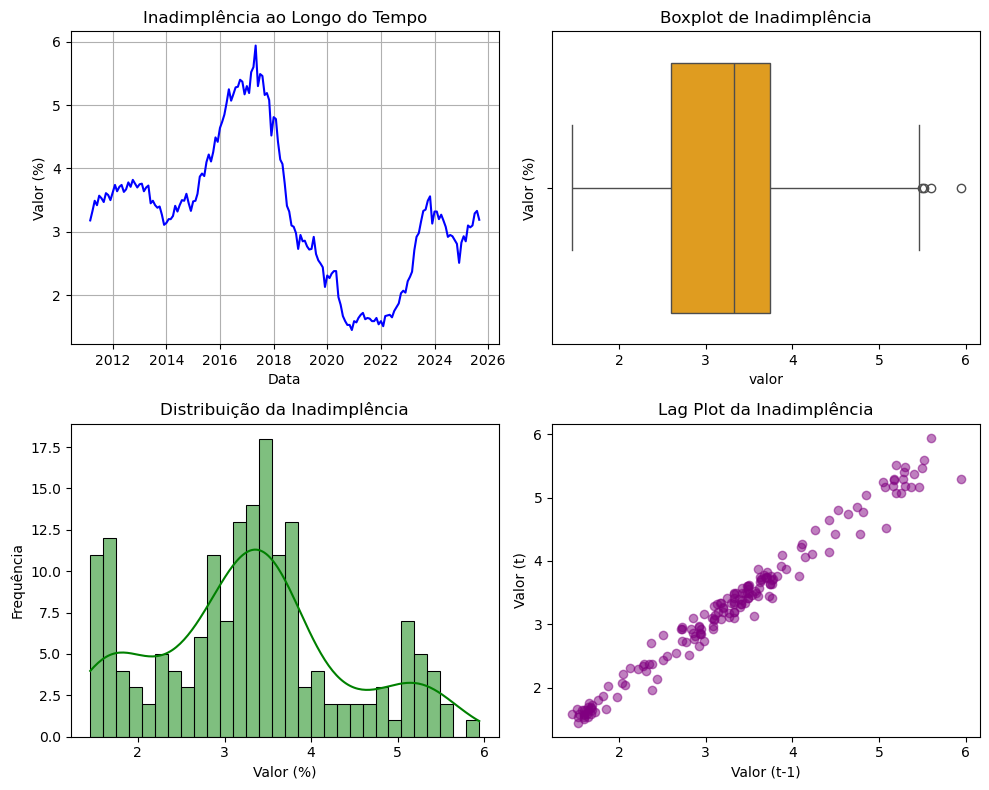

In [434]:
plt.figure(figsize=(12, 10))
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2)

# Gráfico 1: Inadimplência ao Longo do Tempo
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df.index, df['valor'], label='Inadimplência (%)', color='blue')
ax1.set_title('Inadimplência ao Longo do Tempo')
ax1.set_xlabel('Data')
ax1.set_ylabel('Valor (%)')
ax1.grid(True)

# Gráfico 2: Boxplot de Inadimplência
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x=df['valor'], color='orange', ax=ax2)
ax2.set_title('Boxplot de Inadimplência')
ax2.set_ylabel('Valor (%)')

# Gráfico 3: Distribuição da Inadimplência
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(df['valor'], kde=True, color='green', bins=30, ax=ax3)
ax3.set_title('Distribuição da Inadimplência')
ax3.set_xlabel('Valor (%)')
ax3.set_ylabel('Frequência')

# Gráfico 4: Lag Plot
ax4 = fig.add_subplot(gs[1, 1])
pd.plotting.lag_plot(df['valor'], ax=ax4, c='purple', alpha=0.5)
ax4.set_title('Lag Plot da Inadimplência')
ax4.set_xlabel('Valor (t-1)')
ax4.set_ylabel('Valor (t)')

plt.tight_layout()
plt.show()

## 3. Decompor a série de dados em tendência, sazonalidade e componente aleatório;

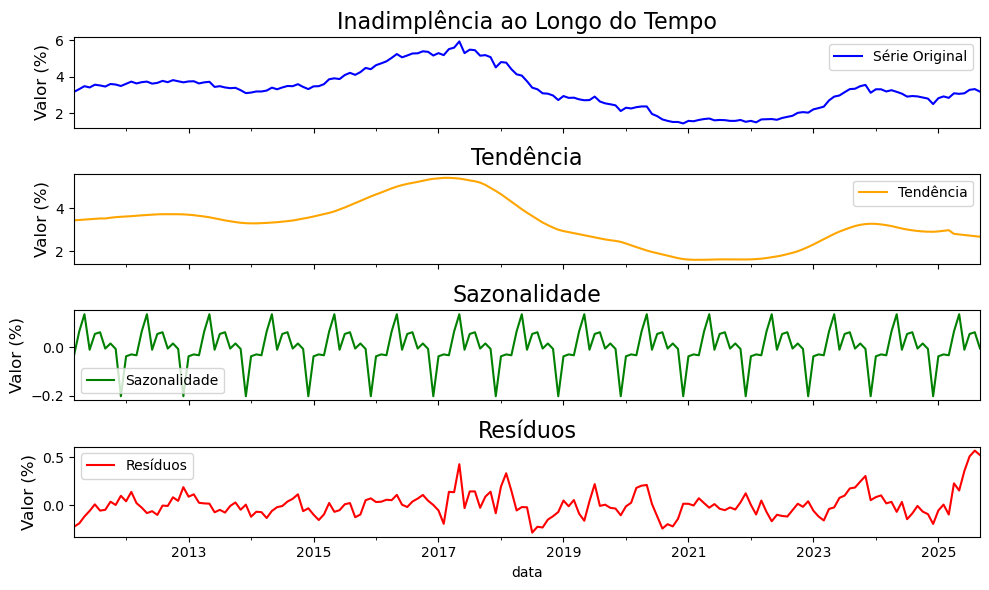

In [435]:
# Para dados mensais, o período de sazonalidade é 12
periodo = 12

# Realizando a decomposição da série temporal
decomposicao = seasonal_decompose(df['valor'], model='additive', period=periodo, extrapolate_trend='freq')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

# 1. Série Original
decomposicao.observed.plot(ax=ax1, color='b', label='Série Original')
ax1.set_ylabel('Valor (%)', fontsize=12)
ax1.set_title('Inadimplência ao Longo do Tempo', fontsize=16)
ax1.legend()

# 2. Tendência
decomposicao.trend.plot(ax=ax2, color='orange', label='Tendência')
ax2.set_ylabel('Valor (%)', fontsize=12)
ax2.set_title('Tendência', fontsize=16)
ax2.legend()

# 3. Sazonalidade
decomposicao.seasonal.plot(ax=ax3, color='g', label='Sazonalidade')
ax3.set_ylabel('Valor (%)', fontsize=12)
ax3.set_title('Sazonalidade', fontsize=16)
ax3.legend()

# 4. Resíduos
decomposicao.resid.plot(ax=ax4, color='r', label='Resíduos')
ax4.set_ylabel('Valor (%)', fontsize=12)
ax4.set_title('Resíduos', fontsize=16)
ax4.legend()

plt.tight_layout()
plt.show()

## 4. Verificar a estacionariedade por:

### a. Análise gráfica;

<Axes: xlabel='data'>

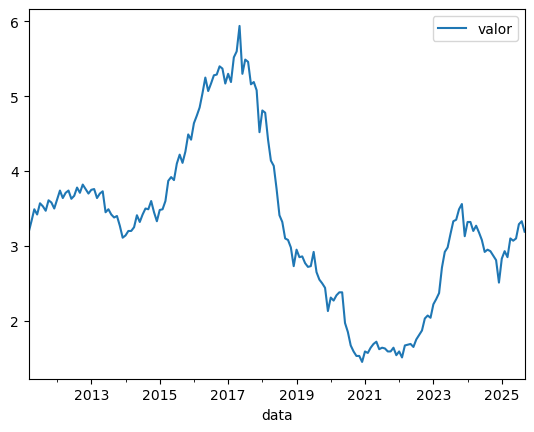

In [436]:
df.plot()

### b. Teste de correlograma;

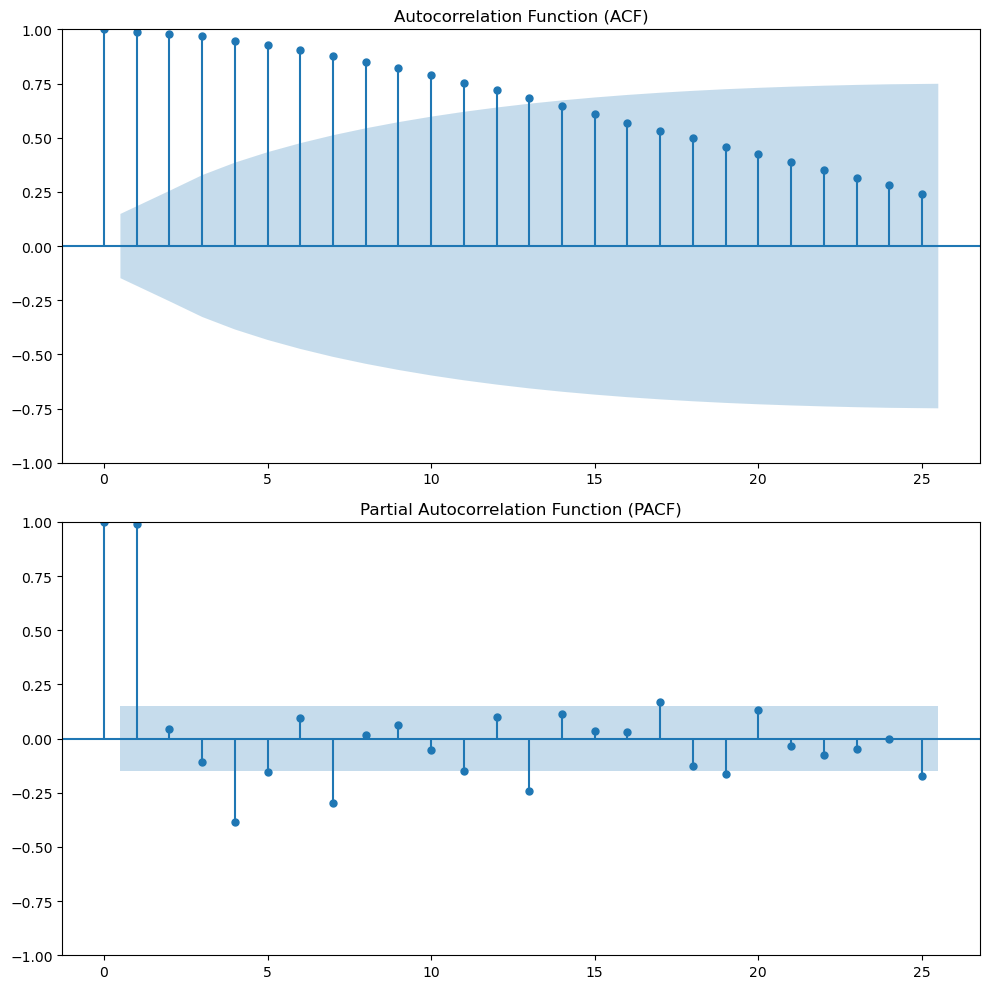

In [437]:
lag_acf = acf(df.valor.dropna(), nlags=25)
lag_pacf = pacf(df.valor.dropna(), nlags=25)

# 1. Cria a figura e os subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# 2. Plota o ACF
# Passamos a série temporal diretamente.
plot_acf(df.valor.dropna(), lags=25, ax=axes[0], title='Autocorrelation Function (ACF)')

# 3. Plota o PACF
# Passamos a série temporal diretamente.
plot_pacf(df.valor.dropna(), lags=25, ax=axes[1], title='Partial Autocorrelation Function (PACF)')

# 4. Ajusta o layout e exibe
plt.tight_layout()
plt.show()

### c. Teste de raiz unitária;

In [438]:
resultado = adfuller(df.valor.dropna())
print('ADF:', resultado[0])
print('p-valor:', resultado[1])

ADF: -2.1294943838974434
p-valor: 0.23282130526352462


### d. Transformar a série (se preciso) em estacionária pelos seguintes critérios:

#### i) Tendência estacionária

In [439]:
df['dados_diff'] = df['valor'].diff()
df['tempo'] = range(len(df))
df.head()

,valor,dados_diff,tempo
data,,,
2011-03-01,3.18,NaN,0
2011-04-01,3.33,0.15,1
2011-05-01,3.49,0.16,2
2011-06-01,3.42,-0.07,3
2011-07-01,3.57,0.15,4


In [440]:
y = df['valor']
x1 = df['tempo']
x = sm.add_constant(x1)
results = sm.OLS(y, x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     49.94
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.73e-11
Time:                        16:00:31   Log-Likelihood:                -240.07
No. Observations:                 175   AIC:                             484.1
Df Residuals:                     173   BIC:                             490.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1672      0.144     28.851      0.0

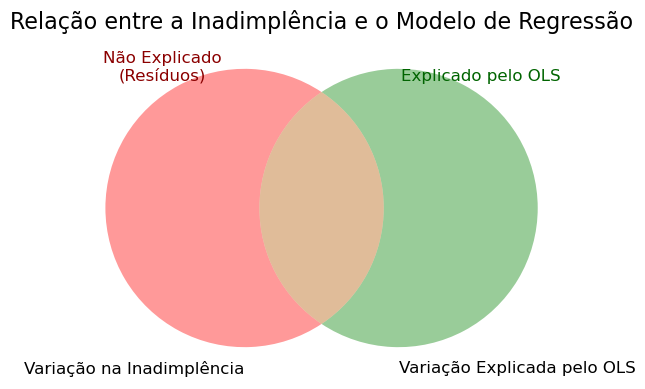

In [441]:
# Criando o diagrama de Venn com dois conjuntos
# A: Variação total na inadimplência
# B: Variação explicada pelo OLS
v = venn2(subsets=(1, 1, 0.5), set_labels=('Variação na Inadimplência', 'Variação Explicada pelo OLS'))

try:
    v.get_label_by_id('10').set_visible(False) # Área de A que não se intersecta
    v.get_label_by_id('01').set_visible(False) # Área de B que não se intersecta
    v.get_label_by_id('11').set_visible(False) # Área da interseção
except AttributeError:
    pass

# Adicionando anotações para clareza
plt.text(-0.5, 0.4, 'Não Explicado\n(Resíduos)', ha='center', fontsize=12, color='darkred')
plt.text(0.5, 0.4, 'Explicado pelo OLS', ha='center', fontsize=12, color='darkgreen')
plt.title("Relação entre a Inadimplência e o Modelo de Regressão", fontsize=16)

plt.show()

<Axes: xlabel='data'>

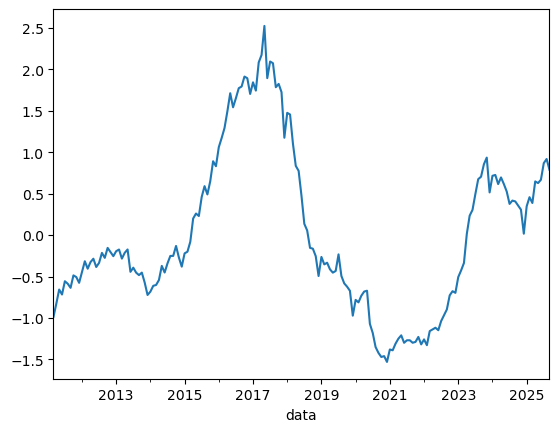

In [442]:
df['valor_sem_tend'] = results.resid
df['valor_sem_tend'].plot()

#### ii) Diferença estacionária;

<Axes: xlabel='data'>

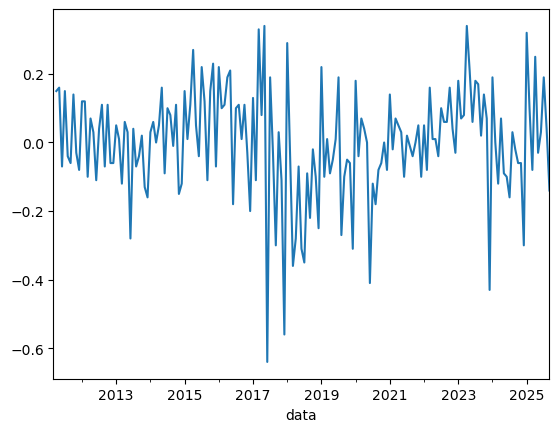

In [443]:
df['dados_diff'].plot()

In [444]:
teste_diferenciado = adfuller(df['dados_diff'].dropna())
print("Valor p:", teste_diferenciado[1])
if teste_diferenciado[1] < 0.05:
    print("Conclusão: A série é estacionária. Prossiga para a modelagem.")
else:
    print("Conclusão: A série ainda não é estacionária. Diferencie novamente ou use outra técnica.")

Valor p: 0.13201741889014834
Conclusão: A série ainda não é estacionária. Diferencie novamente ou use outra técnica.


In [445]:
df['dados_diff_2'] = df['dados_diff'].diff()
display(df)

,valor,dados_diff,tempo,valor_sem_tend,dados_diff_2
data,,,,,
2011-03-01,3.18,NaN,0,-0.987219,NaN
2011-04-01,3.33,0.15,1,-0.827073,NaN
2011-05-01,3.49,0.16,2,-0.656927,0.01
2011-06-01,3.42,-0.07,3,-0.716781,-0.23
2011-07-01,3.57,0.15,4,-0.556635,0.22
...,...,...,...,...,...
2025-05-01,3.07,-0.03,170,0.627607,-0.28
2025-06-01,3.10,0.03,171,0.667753,0.06
2025-07-01,3.29,0.19,172,0.867899,0.16


### e. Plotar as séries transformadas e estacionárias e comparar com as séries originais

<Axes: xlabel='data'>

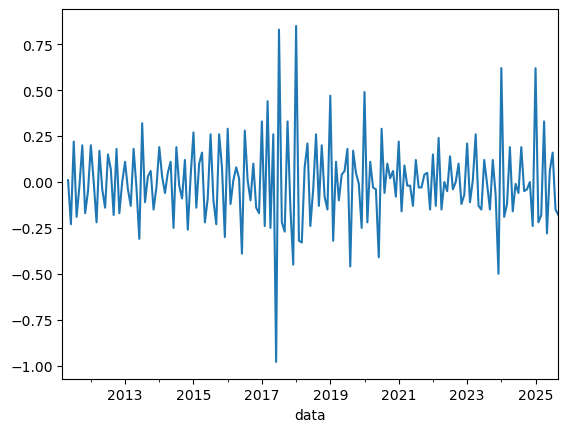

In [446]:
df['dados_diff_2'].plot()

In [447]:
teste_diferenciado = adfuller(df['dados_diff_2'].dropna())
print("Valor p:", teste_diferenciado[1])

if teste_diferenciado[1] < 0.05:
    print("Conclusão: A série é estacionária. Prossiga para a modelagem.")
else:
    print("Conclusão: A série ainda não é estacionária. Diferencie novamente ou use outra técnica.")

Valor p: 2.9884022713158727e-05
Conclusão: A série é estacionária. Prossiga para a modelagem.


### f. Comentar sobre o teste de cointegração (e aplicar, se necessário);

In [448]:
# usar a mesma série já tratada lá em cima
inad_pj = df[['valor']].copy()
inad_pj.rename(columns={'valor': 'inad_pj'}, inplace=True)

In [449]:
# Lista de séries candidatas à cointegração
series_candidatas = [
    {
        "nome": "Inadimplência da carteira de crédito - Pessoas físicas - Total",
        "codigo": 21084,
        "url": "https://api.bcb.gov.br/dados/serie/bcdata.sgs.21084/dados?formato=json"
    },
    {
        "nome": "Índice de Atividade Econômica do Banco Central - IBC-Br",
        "codigo": 24363,
        "url": "https://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=json"
    },
    {
        "nome": "Índice nacional de preços ao consumidor-Amplo (IPCA) - Preços monitorados - Total",
        "codigo": 	4449,
        "url": "https://api.bcb.gov.br/dados/serie/bcdata.sgs.4449/dados?formato=json"
    },
    {
        "nome": "Spread médio das operações de crédito com recursos livres - Pessoas jurídicas - Total",
        "codigo": 20787,
        "url": "https://api.bcb.gov.br/dados/serie/bcdata.sgs.20787/dados?formato=json"
    }
]

In [450]:
resultados = []

for serie in series_candidatas:
    try:
        # Baixa a série candidata
        df_aux = pd.read_json(serie["url"])
        df_aux['data'] = pd.to_datetime(df_aux['data'], dayfirst=True)
        df_aux.set_index('data', inplace=True)
        df_aux.rename(columns={'valor': 'y'}, inplace=True)

        # Junta com a inadimplência PJ
        df_merged = inad_pj.join(df_aux, how='inner')

        # Remove NA, por segurança
        df_merged = df_merged.dropna()

        # Teste de cointegração (Engle-Granger)
        score, pvalue, _ = coint(df_merged['inad_pj'], df_merged['y'])

        resultados.append({
            "nome": serie["nome"],
            "codigo": serie["codigo"],
            "pvalue": pvalue,
            "obs": len(df_merged)
        })

        print(f"{serie['nome']} (cód. {serie['codigo']}): p-valor = {pvalue:.4f} | n = {len(df_merged)}")

    except Exception as e:
        print(f"Erro ao processar {serie['nome']} (cód. {serie['codigo']}): {e}")

Inadimplência da carteira de crédito - Pessoas físicas - Total (cód. 21084): p-valor = 0.5981 | n = 175
Índice de Atividade Econômica do Banco Central - IBC-Br (cód. 24363): p-valor = 0.3239 | n = 175
Índice nacional de preços ao consumidor-Amplo (IPCA) - Preços monitorados - Total (cód. 4449): p-valor = 0.5112 | n = 175
Spread médio das operações de crédito com recursos livres - Pessoas jurídicas - Total (cód. 20787): p-valor = 0.0011 | n = 175


## 5. Apresentar três modelos de séries temporais

### Definição p e q

<Figure size 1200x400 with 0 Axes>

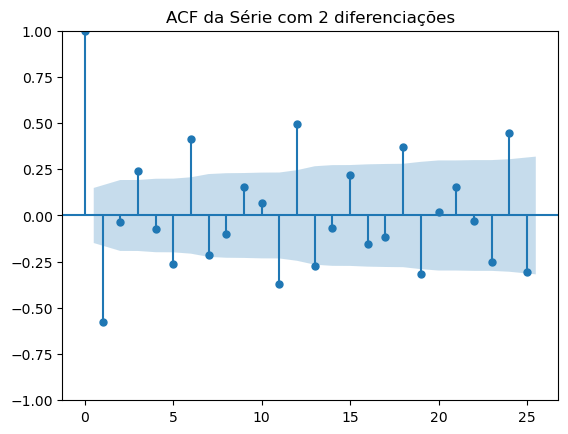

<Figure size 1200x400 with 0 Axes>

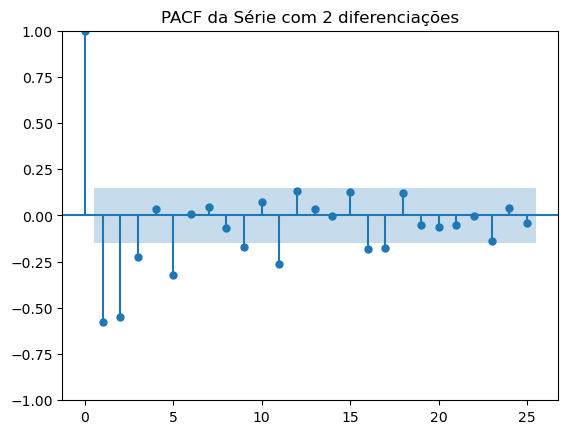

In [451]:
# Série base para modelagem
serie = inad_pj['inad_pj']  # mesma coisa que df['valor'], só renomeada

# --- Duas diferenças só para identificar p e q ---
df_diff2 = serie.diff().diff().dropna()

plt.figure(figsize=(12,4))
plot_acf(df_diff2, lags=25)
plt.title("ACF da Série com 2 diferenciações")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df_diff2, lags=25)
plt.title("PACF da Série com 2 diferenciações")
plt.show()

In [452]:
url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.21086/dados?formato=json"

response = requests.get(url)

data = response.json()
df = pd.DataFrame(data)
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
df['valor'] = df['valor'].str.replace(',', '.').astype(float)
df.set_index('data', inplace=True)

value_series = df['valor'].dropna()

### Holt’s Linear Trend Model

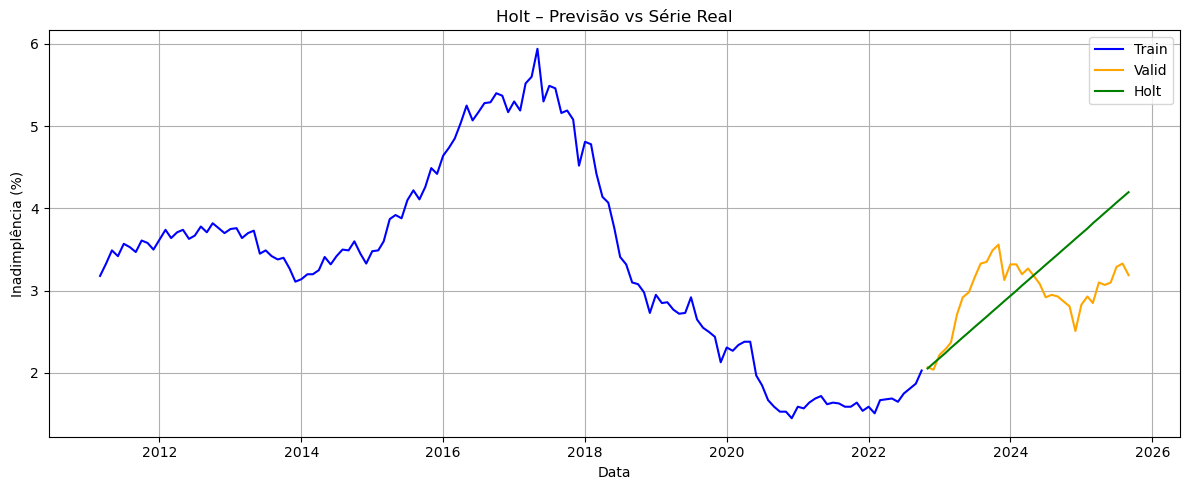

In [453]:
# Divisão treino / validação (80/20)
split = int(len(value_series) * 0.8)
train = value_series.iloc[:split]
valid = value_series.iloc[split:]

# Ajuste do modelo Holt (tendência linear)
holt_model = Holt(train, exponential=False).fit()

# Previsão para o período da validação
holt_forecast = holt_model.forecast(len(valid))

# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(valid.index, valid, label='Valid', color='orange')
plt.plot(holt_forecast.index, holt_forecast, label='Holt', color='green')

plt.title("Holt – Previsão vs Série Real")
plt.xlabel("Data")
plt.ylabel("Inadimplência (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ARIMA (2,2,2)

In [454]:
model = SARIMAX(value_series, order=(2, 2, 2))
results = model.fit()

# Exibir o resumo dos resultados
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  175
Model:               SARIMAX(2, 2, 2)   Log Likelihood                  83.293
Date:                Thu, 20 Nov 2025   AIC                           -156.587
Time:                        16:00:32   BIC                           -140.820
Sample:                    03-01-2011   HQIC                          -150.190
                         - 09-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6443      0.300     -2.151      0.031      -1.231      -0.057
ar.L2         -0.3452      0.093     -3.726      0.000      -0.527      -0.164
ma.L1         -0.4554      0.314     -1.452      0.1

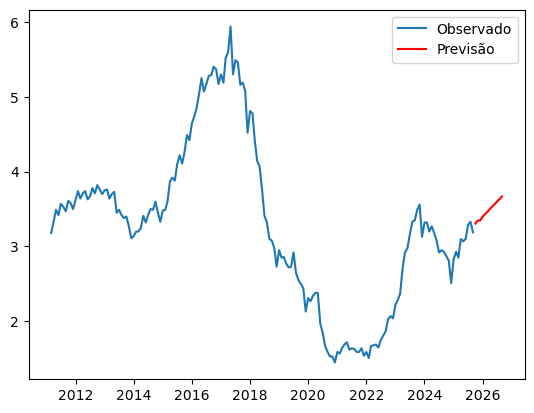

In [455]:
# Fazer previsões
forecast = results.forecast(steps=12)

# Plotar as previsões
plt.plot(value_series, label='Observado')
plt.plot(forecast, label='Previsão', color='red')
plt.legend()
plt.show()

### SARIMA com Grid Search

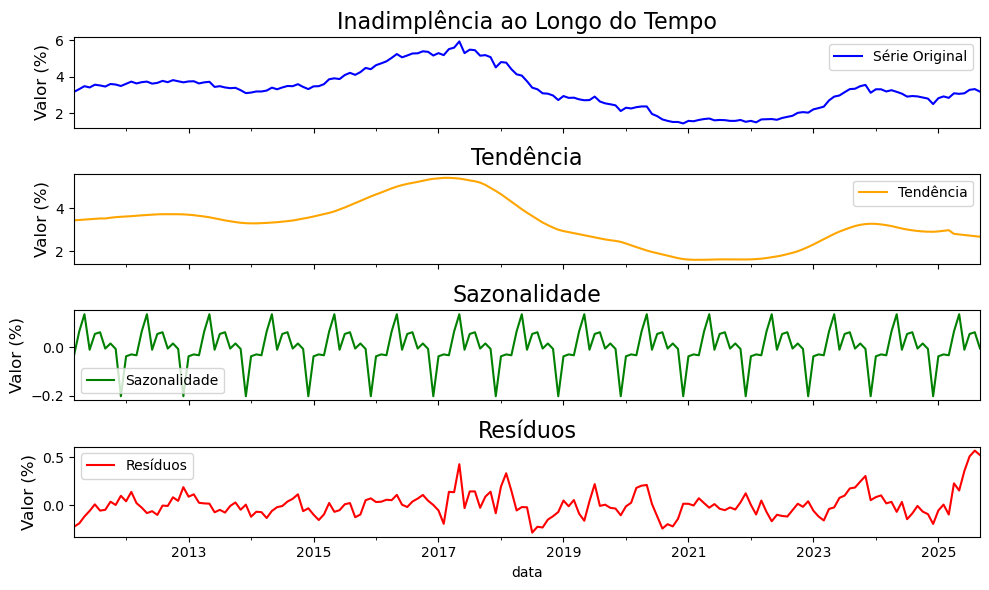

In [456]:
# Para dados mensais, o período de sazonalidade é 12
periodo = 12

# Realizando a decomposição da série temporal
decomposicao = seasonal_decompose(df['valor'], model='additive', period=periodo, extrapolate_trend='freq')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

# 1. Série Original
decomposicao.observed.plot(ax=ax1, color='b', label='Série Original')
ax1.set_ylabel('Valor (%)', fontsize=12)
ax1.set_title('Inadimplência ao Longo do Tempo', fontsize=16)
ax1.legend()

# 2. Tendência
decomposicao.trend.plot(ax=ax2, color='orange', label='Tendência')
ax2.set_ylabel('Valor (%)', fontsize=12)
ax2.set_title('Tendência', fontsize=16)
ax2.legend()

# 3. Sazonalidade
decomposicao.seasonal.plot(ax=ax3, color='g', label='Sazonalidade')
ax3.set_ylabel('Valor (%)', fontsize=12)
ax3.set_title('Sazonalidade', fontsize=16)
ax3.legend()

# 4. Resíduos
decomposicao.resid.plot(ax=ax4, color='r', label='Resíduos')
ax4.set_ylabel('Valor (%)', fontsize=12)
ax4.set_title('Resíduos', fontsize=16)
ax4.legend()

plt.tight_layout()
plt.show()

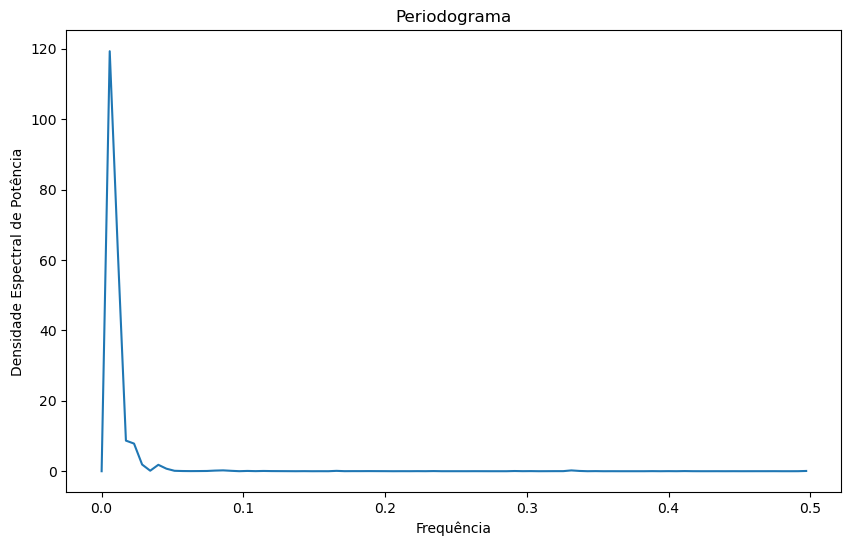

In [457]:
# Certifique-se de que a coluna Value está em formato de série temporal
value_series = df['valor'].dropna()

# Calcular o periodograma usando scipy
frequencies, power_spectral_density = periodogram(value_series)

# Plotar o periodograma
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectral_density)
plt.title('Periodograma')
plt.xlabel('Frequência')
plt.ylabel('Densidade Espectral de Potência')
plt.show()

In [458]:
# Ajuste do modelo SARIMA automaticamente
auto_model = auto_arima(value_series,
                           seasonal=True,
                           m=12,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

# Verificar os melhores parâmetros encontrados
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-203.206, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-143.424, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-169.217, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-158.778, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-145.424, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-172.592, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-182.562, Time=0.51 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-203.264, Time=1.38 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-194.912, Time=1.40 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-202.062, Time=1.65 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-195.647, Time=1.33 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=-198.492, Time=1.24 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=-197.442, Time=1.20 sec
 ARIMA(3,1,2)(2,0,1)[12] intercept   : AIC=-198.358, Time=1.62 sec
 ARIMA(2,1,3)(2,0,1

In [459]:
print(auto_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  175
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 114.512
Date:                              Thu, 20 Nov 2025   AIC                           -211.024
Time:                                      16:02:21   BIC                           -182.592
Sample:                                  03-01-2011   HQIC                          -199.490
                                       - 09-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4649      0.060      7.735      0.000       0.347       0.583
ar.L2         -0.44

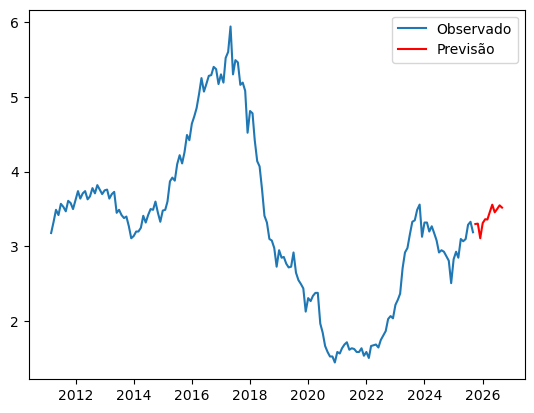

In [460]:
# Ajustar um modelo SARIMA com parâmetros (p,d,q) e (P,D,Q,m)

model = SARIMAX(value_series, order=(3, 1, 3), seasonal_order=(1, 0, 1, 12))
results = model.fit()

# Fazer previsões
forecast = results.forecast(steps=12)

# Plotar as previsões
plt.plot(value_series, label='Observado')
plt.plot(forecast, label='Previsão', color='red')
plt.legend()
plt.show()

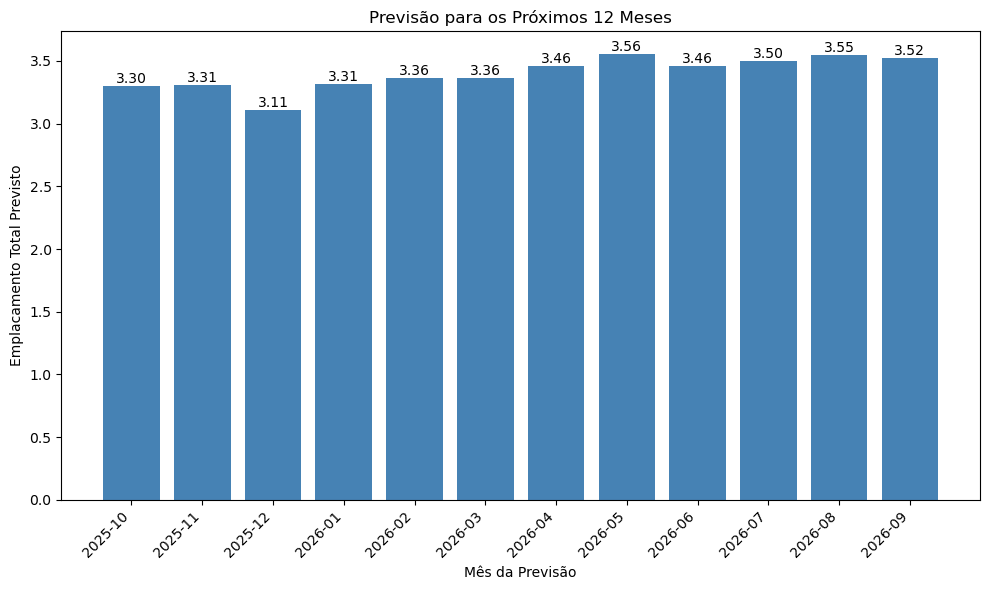

In [461]:
# 1. Preparar os dados para o gráfico
x_labels = forecast.index.strftime('%Y-%m')
y_values = forecast.values

# 2. Criar a figura e os eixos (precisamos do 'ax')
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Criar o gráfico de barras e salvar os objetos 'bars'
bars = ax.bar(x_labels, y_values, color='steelblue')

# 4. ADICIONAR OS RÓTULOS (A MÁGICA ACONTECE AQUI)
#    ax.bar_label() é a forma moderna de fazer isso.
#    fmt='%d' formata o número como um inteiro (ex: 9149)
ax.bar_label(bars, fmt='%.2f')

# 5. Adicionar títulos e rótulos
ax.set_title('Previsão para os Próximos 12 Meses')
ax.set_xlabel('Mês da Previsão')
ax.set_ylabel('Emplacamento Total Previsto')

# 6. Girar os rótulos do eixo X para que não se sobreponham
plt.xticks(rotation=45, ha='right')

# 7. Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()

In [464]:
predictions = results.predict(start=0, end=len(df)-1)

# Calcular o erro quadrático médio
mse = mean_squared_error(df['valor'], predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.07293115058116974


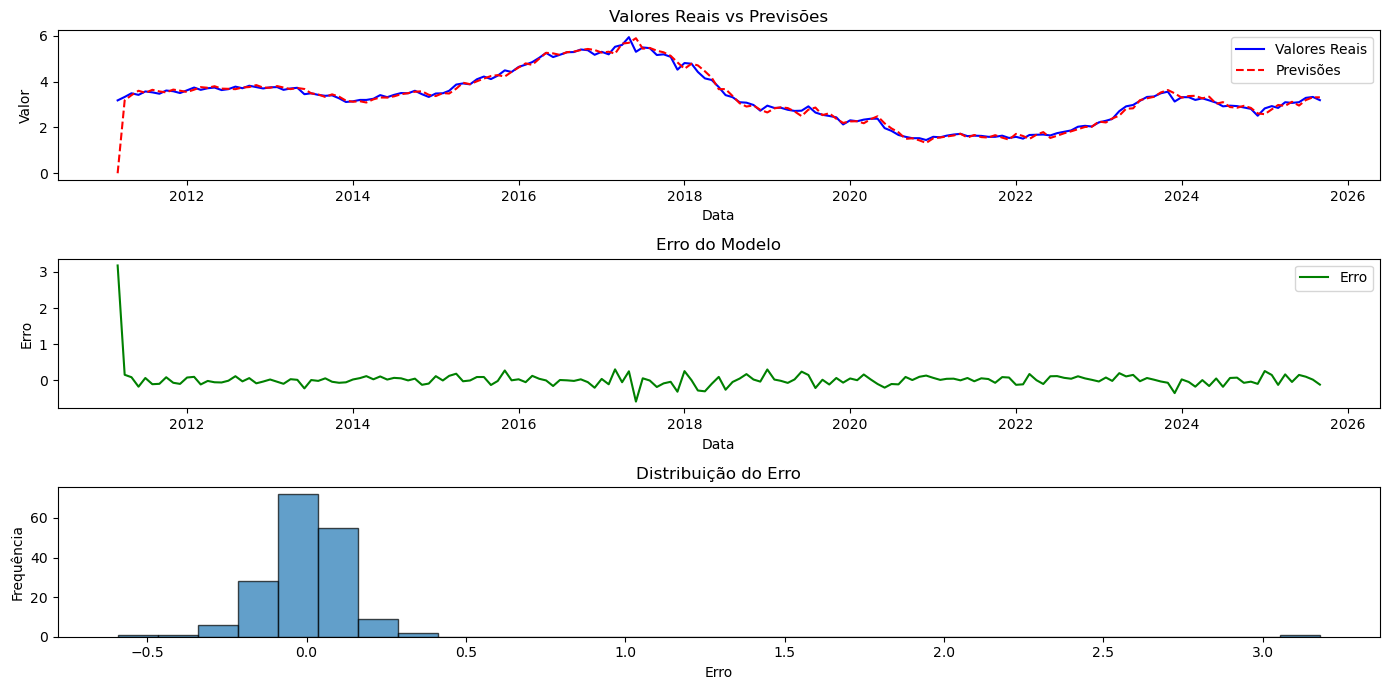

In [466]:
# Plotar os valores reais, previsões e erro
plt.figure(figsize=(14, 7))

# Plotar valores reais e previsões
plt.subplot(3, 1, 1)
plt.plot(df.index, df['valor'], label='Valores Reais', color='blue')
plt.plot(df.index, predictions, label='Previsões', color='red', linestyle='--')
plt.title('Valores Reais vs Previsões')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()

# Calcular o erro
error = df['valor'] - predictions

# Plotar erro
plt.subplot(3, 1, 2)
plt.plot(df.index, error, label='Erro', color='green')
plt.title('Erro do Modelo')
plt.xlabel('Data')
plt.ylabel('Erro')
plt.legend()

# Plotar histograma do erro
plt.subplot(3, 1, 3)
plt.hist(error, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Erro')
plt.xlabel('Erro')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [469]:
# -----------------------------------------------------------------
# PARTE 1: DATAFRAME DE HISTÓRICO (Ajuste)
# -----------------------------------------------------------------
# (Assumindo que 'value_series' e 'predictions' já existem no seu ambiente)

df_historico = pd.DataFrame(value_series)
df_historico = df_historico.rename(columns={'valor': 'Valor Original'})
df_historico['Valor Previsto'] = predictions
df_historico['Erro'] = df_historico['Valor Original'] - df_historico['Valor Previsto']

# -----------------------------------------------------------------
# PARTE 2: DATAFRAME DO FUTURO (Previsão)
# -----------------------------------------------------------------
# (Assumindo que 'forecast' já existe no seu ambiente)

# Transforma a Série 'forecast' em um DataFrame com o nome de coluna correto
df_futuro = pd.DataFrame(forecast, columns=['Valor Previsto'])

# -----------------------------------------------------------------
# PARTE 3: COMBINAR OS DATAFRAMES (A SOLUÇÃO)
# -----------------------------------------------------------------

# pd.concat 'empilha' os dois DataFrames.
# Colunas que não existem em um ou outro (ex: 'Erro')
# são preenchidas com NaN, que é exatamente o que queremos.
df_final = pd.concat([df_historico, df_futuro])

# -----------------------------------------------------------------
# PARTE 4: IMPRIMIR E SALVAR (Seu código original)
# -----------------------------------------------------------------

print("--- Tabela de Valores (Histórico e Previsão) ---")
print("Últimos 20 registros (mostrando a transição para o futuro):")
print(df_final.tail(20))

# -----------------------------------------------------------------
# PARTE 5: CALCULAR O ERRO PERCENTUAL GERAL (MAPE)
# -----------------------------------------------------------------
print("\n--- Erro Percentual Geral (de Ajuste) ---")

# (Este código continua funcionando perfeitamente)
# O .dropna() vai selecionar apenas as linhas do histórico
# (pois o futuro tem NaN em 'Valor Original')
temp_df = df_final[['Valor Original', 'Valor Previsto']].dropna()
temp_df = temp_df[temp_df['Valor Original'] != 0]

mape_in_sample = np.mean(np.abs((temp_df['Valor Original'] - temp_df['Valor Previsto']) / temp_df['Valor Original'])) * 100

print(f"Erro Percentual Absoluto Médio (MAPE) de Ajuste: {mape_in_sample:.2f}%")
print(f"Isto significa que, ao 'descrever' o passado, o modelo teve um erro médio de {mape_in_sample:.2f}%.")

--- Tabela de Valores (Histórico e Previsão) ---
Últimos 20 registros (mostrando a transição para o futuro):
            Valor Original  Valor Previsto      Erro
2024-02-01            3.32        3.368972 -0.048972
2024-03-01            3.20        3.379091 -0.179091
2024-04-01            3.27        3.267827  0.002173
2024-05-01            3.18        3.341121 -0.161121
2024-06-01            3.08        3.032566  0.047434
2024-07-01            2.92        3.103370 -0.183370
2024-08-01            2.95        2.888218  0.061782
2024-09-01            2.93        2.859337  0.070663
2024-10-01            2.87        2.942863 -0.072863
2024-11-01            2.81        2.850952 -0.040952
2024-12-01            2.51        2.612083 -0.102083
2025-01-01            2.83        2.576463  0.253537
2025-02-01            2.93        2.785781  0.144219
2025-03-01            2.85        2.979897 -0.129897
2025-04-01            3.10        2.939019  0.160981
2025-05-01            3.07        3.118819 